In [1]:
import time

import mne
import numpy as np


from mne import set_log_level

import statsmodels.api as sm

from mne_lsl.player import PlayerLSL as Player
from mne_lsl.stream import StreamLSL as Stream

set_log_level("WARNING")

eeg_path = r'C:\Users\Victor\Documents\GitHub\neuxus_test\P05_eyes_open_mrion.vhdr'
raw = mne.io.read_raw_brainvision(eeg_path, preload=True)

player = Player(raw).start()
player.info

Measurement date,"January 10, 2024 12:58:09 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,36 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,5000.00 Hz
Highpass,0.02 Hz
Lowpass,250.00 Hz


In [2]:
tr = 1.6
n_tr = 7

bufsize = (n_tr + 1) * tr
stream = Stream(bufsize=bufsize, name='MNE-LSL-Player').connect()
stream.info

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,36 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,5000.00 Hz
Highpass,0.02 Hz
Lowpass,250.00 Hz


C:\Users\Victor\AppData\Local\Temp\ipykernel_14548\466342801.py:3: RuntimeWarning: The unit for channel(s) CWL1, CWL2, CWL3, CWL4 has changed from V to NA.
  raw.set_channel_types({'CWL1': 'misc', 'CWL2': 'misc', 'CWL3': 'misc', 'CWL4': 'misc', 'ECG': 'ecg'})


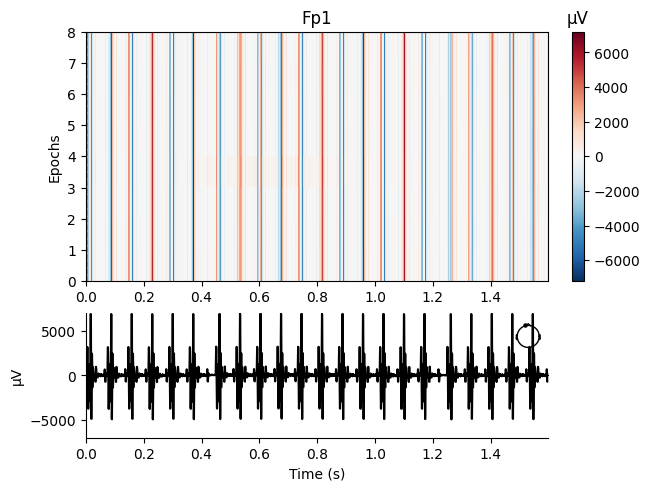

In [6]:
data, timestamps = stream.get_data(bufsize * stream.info['sfreq'])
raw = mne.io.RawArray(data, stream.info)
raw.set_channel_types({'CWL1': 'misc', 'CWL2': 'misc', 'CWL3': 'misc', 'CWL4': 'misc', 'ECG': 'ecg'})
raw.set_montage('standard_1020')

epochs = mne.make_fixed_length_epochs(raw, duration=tr, overlap=0, preload=True)
average = epochs[:-1].average(picks='all')
clean_epoch_data = epochs[-1].get_data(picks=average.ch_names)[0] - average.data

ga_corrected = mne.io.RawArray(clean_epoch_data, epochs.info)
event_related_plot = epochs.plot_image(picks=["Fp1"])

In [7]:
raw.copy().crop(tmin=raw.times[-1] - tr).plot()
ga_corrected.plot(scalings='auto')
raw_cba.plot(scalings='auto')

NameError: name 'raw_cba' is not defined

d:\Python\envs\mne_lsl\lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
d:\Python\envs\mne_lsl\lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


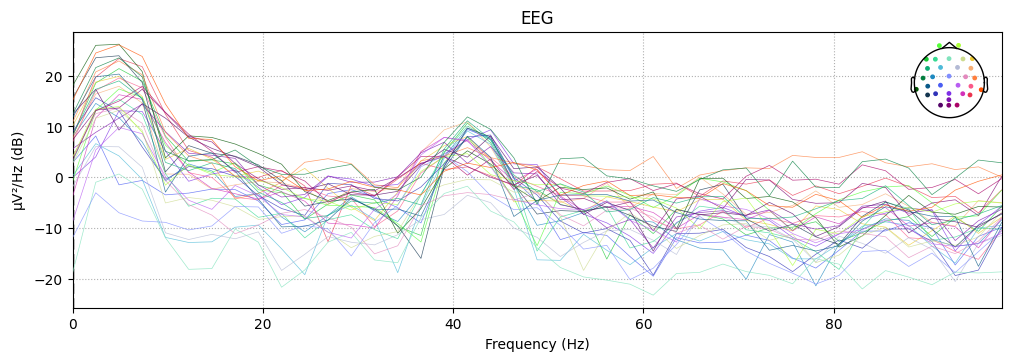

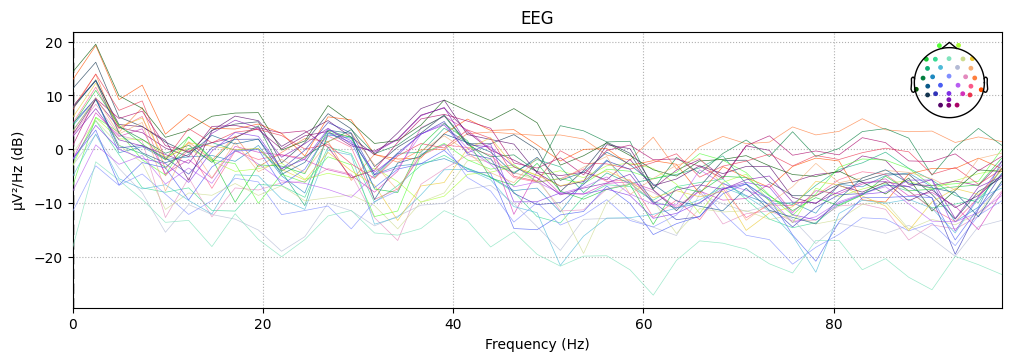

In [30]:
ga_corrected.compute_psd(fmin=0, fmax=100).plot(spatial_colors=True);
raw_cba.compute_psd(fmin=0, fmax=100).plot(spatial_colors=True);

In [1]:
import numpy as np
from numba import njit
# pip install -U numpy==1.24 for numba


@njit
def create_time_lag_signals(X, Y, sample_freq, min_lag, max_lag):
    # Calculate number of samples for each lag
    num_samples = int((max_lag - min_lag) * sample_freq) + 1
    
    # Initialize array to store time lag signals
    time_lag_signals = np.zeros((num_samples, len(X)))
    
    # Iterate through each lag value and generate time lagged signals
    for i, lag in enumerate(np.linspace(min_lag, max_lag, num_samples)):
        # Calculate index offset based on time lag
        offset = int(round(lag * sample_freq))
        
        # Shift signal Y by the offset
        shifted_Y = np.roll(Y, offset)
        
        # Clip the shifted signal to match the length of X
        if offset > 0:
            shifted_Y[:offset] = Y[0]
        elif offset < 0:
            shifted_Y[offset:] = Y[-1]
        
        # Store the time lagged signal
        time_lag_signals[i] = shifted_Y
    
    return time_lag_signals

# Example usage
# Assuming X and Y are numpy arrays sampled at the same frequency
X = np.array([1, 2, 3, 4, 5])
Y = np.array([0.5, 1, 1.5, 2, 2.5])
sample_freq = 1  # Sample frequency in Hz
min_lag = -1  # Minimum lag in seconds
max_lag = 1   # Maximum lag in seconds

# Create time lag signals
time_lag_signals = create_time_lag_signals(X, Y, sample_freq, min_lag, max_lag)

In [8]:
import numpy as np
from numba import njit
from sklearn.linear_model import LinearRegression


import numpy as np
from sklearn.linear_model import LinearRegression

def create_time_lag_signals(X, Y, sample_freq, min_lag, max_lag):
    # Calculate number of samples for each lag
    num_samples = int((max_lag - min_lag) * sample_freq) + 1
    
    # Initialize array to store time lag signals
    time_lag_signals = np.zeros((num_samples, len(Y)))
    
    # Iterate through each lag value and generate time lagged signals
    for i, lag in enumerate(np.linspace(min_lag, max_lag, num_samples)):
        # Calculate index offset based on time lag
        offset = int(round(lag * sample_freq))
        
        # Shift signal Y by the offset
        shifted_Y = np.roll(Y, offset)
        
        # Pad the shifted signal if necessary
        if offset > 0:
            shifted_Y[:offset] = np.nan  # or any appropriate padding value
        elif offset < 0:
            shifted_Y[offset:] = np.nan  # or any appropriate padding value
        
        # Store the time lagged signal
        time_lag_signals[i] = shifted_Y
    return time_lag_signals

def regress_lag_signals(X, time_lag_signals):
    # Initialize array to store residuals
    residuals = np.zeros_like(time_lag_signals)
    
    # Perform linear regression for each lag signal
    for i in range(time_lag_signals.shape[0]):
        model = LinearRegression()
        # Remove NaN values from X and the corresponding lag signal
        non_nan_indices = np.logical_not(np.isnan(time_lag_signals[i]))
        model.fit(X[non_nan_indices].reshape(-1, 1), time_lag_signals[i][non_nan_indices])
        predicted = model.predict(X.reshape(-1, 1))
        residuals[i] = time_lag_signals[i] - predicted
    
    return residuals

# Example usage
# Assuming X and Y are numpy arrays sampled at the same frequency
X = ga_corrected.get_data()[0]
Y = ga_corrected.get_data()[1]
sample_freq = raw.info['sfreq']  # Sample frequency in Hz
min_lag = -0.1  # Minimum lag in seconds
max_lag = 0.1   # Maximum lag in seconds

# Create time lag signals
time_lag_signals = create_time_lag_signals(X, Y, sample_freq, min_lag, max_lag)

# Perform regression and collect residuals
residuals = regress_lag_signals(X, time_lag_signals)


In [39]:
# Create time lag signals
time_lag_signals = create_time_lag_signals(X, Y, sample_freq, min_lag, max_lag)

# Perform regression and collect residuals
residuals = regress_lag_signals(X, time_lag_signals)

In [21]:
from mne.parallel import parallel_func

def create_time_lag_signals(Y, sample_freq, min_lag, max_lag):
    # Calculate number of samples for each lag
    num_samples = int((max_lag - min_lag) * sample_freq) + 1
    
    # Initialize array to store time lag signals
    time_lag_signals = np.zeros((num_samples, len(Y)))
    
    # Iterate through each lag value and generate time lagged signals
    for i, lag in enumerate(np.linspace(min_lag, max_lag, num_samples)):
        # Calculate index offset based on time lag
        offset = int(round(lag * sample_freq))
        
        # Shift signal Y by the offset
        shifted_Y = np.roll(Y, offset)
        
        # Pad the shifted signal if necessary
        if offset > 0:
            shifted_Y[:offset] = 0 # or any appropriate padding value
        elif offset < 0:
            shifted_Y[offset:] = 0  # or any appropriate padding value
        
        # Store the time lagged signal
        time_lag_signals[i] = shifted_Y
    return time_lag_signals


def index_to_signal(index, data, lags_signals_to_regress):
    signal = data[index, :]
    # Perform multiple linear regression
    X = sm.add_constant(lags_signals_to_regress)
    model = sm.OLS(signal, X).fit()
    # Extract coefficients
    coefficients = model.params[1:]
    # Calculate the predicted values of the signals to regress out
    predicted_signals_to_regress = np.dot(lags_signals_to_regress, coefficients)
    # Calculate the residuals (signals after regressing out the effects of the 4 signals)
    residuals = signal - predicted_signals_to_regress
    return(residuals)
        
def cba(raw, picks=['eeg', 'ecg'], cwl_ch_names=['CWL1', 'CWL2', 'CWL3', 'CWL4'], lag=0.1, n_jobs=1, verbose=None):
    
    pick_indices = mne._fiff.pick._picks_to_idx(raw.info, picks=picks)
    cwl_indices = mne._fiff.pick._picks_to_idx(raw.info, picks=cwl_ch_names)

    data = raw.get_data()

    signals_to_regress = data[cwl_indices, :]
    lags_signals_to_regress = list()
    for signal in signals_to_regress:
        lags_combined = create_time_lag_signals(signal, sample_freq=raw.info['sfreq'], min_lag=-lag, max_lag=lag)
        lags_signals_to_regress.append(lags_combined)
        
    lags_signals_to_regress = np.vstack(lags_signals_to_regress).T
    corrected_data = np.zeros_like(data)

    if n_jobs == 1:
        for index in pick_indices:
            residuals = index_to_signal(index, data, lags_signals_to_regress)
            corrected_data[index] = residuals

    else:
        parallel, p_fun, _ = parallel_func(
            index_to_signal, n_jobs, total=len(pick_indices), verbose=verbose
        )
        corrected_signals = parallel(
            p_fun(index, data, lags_signals_to_regress)
            for index in pick_indices
        )
        for index, signal in zip(pick_indices,corrected_signals):
            corrected_data[index] = signal
    
    raw_corrected = mne.io.RawArray(data=corrected_data, info=raw.info, verbose=verbose)
    raw_corrected.set_annotations(raw.annotations)
    return(raw_corrected)

In [22]:
pick_indices = mne._fiff.pick._picks_to_idx(raw.info, picks=['eeg'])
cwl_indices = mne._fiff.pick._picks_to_idx(raw.info, picks=['CWL1', 'CWL2', 'CWL3', 'CWL4'])

In [23]:
ga_corrected_resampled = ga_corrected.copy().resample(250)

In [25]:
raw_cba = cba(ga_corrected_resampled, lag=0.1, n_jobs=4)

d:\Python\envs\mne_lsl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


d:\Python\envs\mne_lsl\lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


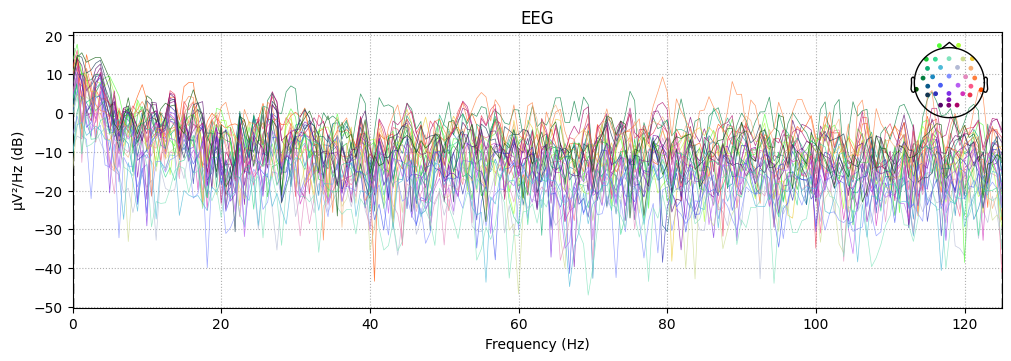

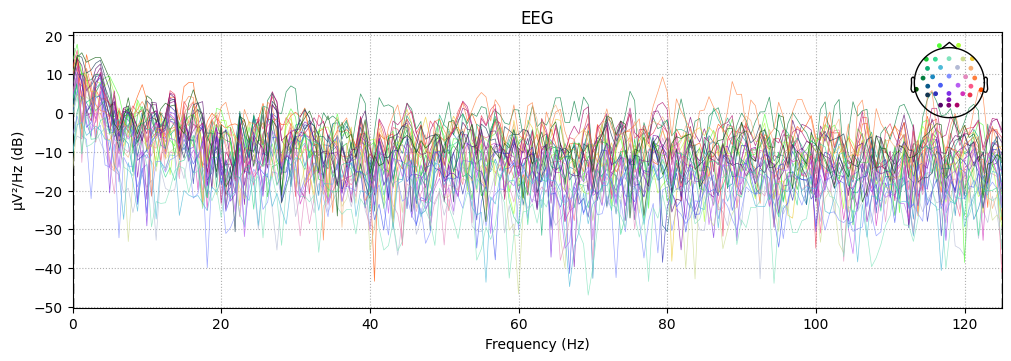

In [28]:
raw_cba.compute_psd().plot()